In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from models.adam import ADAM
from models.irls import IRLS
from models.sgd import SGD
from datasets.read import read_all_datasets

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Task 3.4
Compare the classification performance of logistic regression (try all 3 methods: IWLS, SGD and ADAM) and 4 popular classification methods: LDA (Linear Discriminant analysis), QDA (Quadratic Discriminant Analysis), Decision tree and Random Forest. 
Use available implementations, e.g. from scikit-learn library.

In [4]:
# Load saved datasets
import cloudpickle

try:
    with open('datasets.pkl', 'rb') as f:
        datasets = cloudpickle.load(f)
        print("Loaded datasets from file")
except FileNotFoundError:
    datasets = None

if datasets is None:
    datasets = read_all_datasets('datasets/')


Loaded datasets from file


In [31]:
# Save datasets
import cloudpickle

with open('datasets.pkl', 'wb') as f:
    cloudpickle.dump(datasets, f)

In [5]:
# Print shapes of datasets
for dataset_name, dataset in datasets.items():
    X, y = dataset
    print(f"{dataset_name}: {X.shape}, {y.shape}")

Rice_Cammeo_Osmancik: (3810, 7), (3810,)
Online_Shoppers_intention: (12330, 17), (12330,)
Dataset_for_Link_Phishing: (19431, 68), (19431,)
Banknote_Authentication: (1372, 4), (1372,)
Optdigits: (5620, 38), (5620,)
EEG_Eye_State: (14980, 4), (14980,)
Web_Page_Phishing: (100077, 19), (100077,)
Statlog_Shuttle: (58000, 6), (58000,)
Airline_Passenger_Satisfaction: (64744, 14), (64744,)


In [38]:
import traceback
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

iterations = 5
test_size = 0.3
methods = [
    ("LDA", lambda: LinearDiscriminantAnalysis()),
    ("QDA", lambda: QuadraticDiscriminantAnalysis()),
    ("Decision Tree", lambda: DecisionTreeClassifier()),
    ("Random Forest", lambda: RandomForestClassifier()),
    ("IWLS", lambda: IRLS(iter_limit=10)),
    ("SGD", lambda: SGD(iter_limit=500)),
    ("ADAM", lambda: ADAM(iter_limit=500))
]

results_by_dataset_and_method = {}

# Load saved results
import json

try:
    with open('results.json', 'r') as f:
        results_by_dataset_and_method = json.load(f)
        print("Loaded results from file")
except FileNotFoundError:
    pass

# First collect results 
for dataset_name, dataset in datasets.items():
    if dataset_name in results_by_dataset_and_method:
        print(f"Skipping {dataset_name}")
        continue
    
    results_by_method = {}
    for method_name, method in methods:
        results = {
            "accuracy": [],
            "f1": [],
            "precision": [],
            "recall": []
        }
        
        tqdm._instances.clear()
        
        bar = tqdm(total=iterations)
        bar.set_description(f"Processing {method_name} on {dataset_name}")
        max_attempts = 10
        current_iteration = 0
        while current_iteration < iterations:
            try:
                X, y = dataset
                method_instance = method()
    
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
                method_instance.fit(X_train, y_train)
                y_pred = method_instance.predict(X_test)
                results["accuracy"].append(accuracy_score(y_test, y_pred))
                results["f1"].append(f1_score(y_test, y_pred))
                results["precision"].append(precision_score(y_test, y_pred))
                results["recall"].append(recall_score(y_test, y_pred))

                bar.update(1)
                current_iteration += 1
            except Exception as e:
                print(f"Error in {method_name} on {dataset_name} iteration {current_iteration}: {e}, attempts left: {max_attempts}")
                traceback.print_exc()
                max_attempts -= 1
                
                if max_attempts == 0:
                    raise
            
        bar.close()
        results_by_method[method_name] = results
    results_by_dataset_and_method[dataset_name] = results_by_method
    
    # Save results
    with open('results.json', 'w') as f:
        json.dump(results_by_dataset_and_method, f)

Processing SGD on Rice_Cammeo_Osmancik:  20%|██        | 1/5 [00:00<00:03,  1.07it/s]/Users/nk2/workspace/AdvMachineLearning/aml_projects/Project1/models/util.py:33: UserWarning: Classes in y are not the same as source classes. Will attempt to map anyway. [1] != [-1, 1]
  warnings.warn(f"Classes in y are not the same as source classes. "
Processing SGD on Rice_Cammeo_Osmancik:  60%|██████    | 3/5 [00:02<00:01,  1.13it/s]/Users/nk2/workspace/AdvMachineLearning/aml_projects/Project1/models/util.py:33: UserWarning: Classes in y are not the same as source classes. Will attempt to map anyway. [1] != [-1, 1]
  warnings.warn(f"Classes in y are not the same as source classes. "
Processing SGD on Rice_Cammeo_Osmancik:  80%|████████  | 4/5 [00:03<00:00,  1.14it/s]/Users/nk2/workspace/AdvMachineLearning/aml_projects/Project1/models/util.py:33: UserWarning: Classes in y are not the same as source classes. Will attempt to map anyway. [-1] != [-1, 1]
  warnings.warn(f"Classes in y are not the same 

KeyboardInterrupt: 

In [1]:
# Save results
import json

with open('results.json', 'w') as f:
    json.dump(results_by_dataset_and_method, f)


NameError: name 'results_by_dataset_and_method' is not defined

In [35]:
results_by_dataset_and_method

{'Rice_Cammeo_Osmancik': {'LDA': {'accuracy': [0.9343832020997376],
   'f1': [0.9206349206349206],
   'precision': [0.9375],
   'recall': [0.9043659043659044]},
  'QDA': {'accuracy': [0.9247594050743657],
   'f1': [0.9161793372319688],
   'precision': [0.9003831417624522],
   'recall': [0.9325396825396826]},
  'Decision Tree': {'accuracy': [0.8775153105861767],
   'f1': [0.8577235772357723],
   'precision': [0.8559837728194726],
   'recall': [0.8594704684317719]},
  'Random Forest': {'accuracy': [0.9230096237970253],
   'f1': [0.9087136929460581],
   'precision': [0.8975409836065574],
   'recall': [0.9201680672268907]},
  'IWLS': {'accuracy': [0.931758530183727],
   'f1': [0.918580375782881],
   'precision': [0.9322033898305084],
   'recall': [0.9053497942386831]},
  'SGD': {'accuracy': [0.5879265091863517],
   'f1': [0.0],
   'precision': [0.0],
   'recall': [0.0]},
  'ADAM': {'accuracy': [0.689413823272091],
   'f1': [0.4246353322528363],
   'precision': [0.9703703703703703],
   'rec

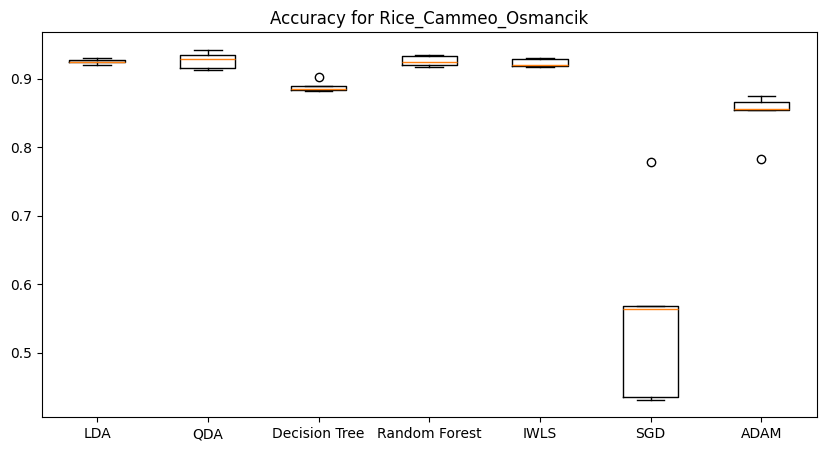

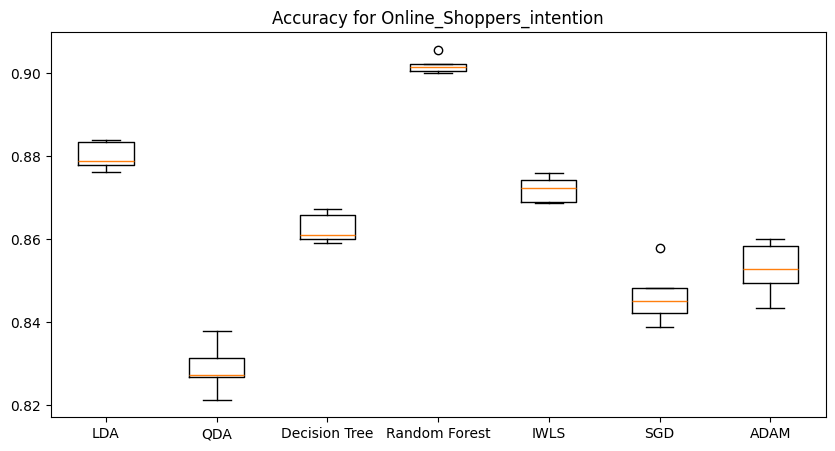

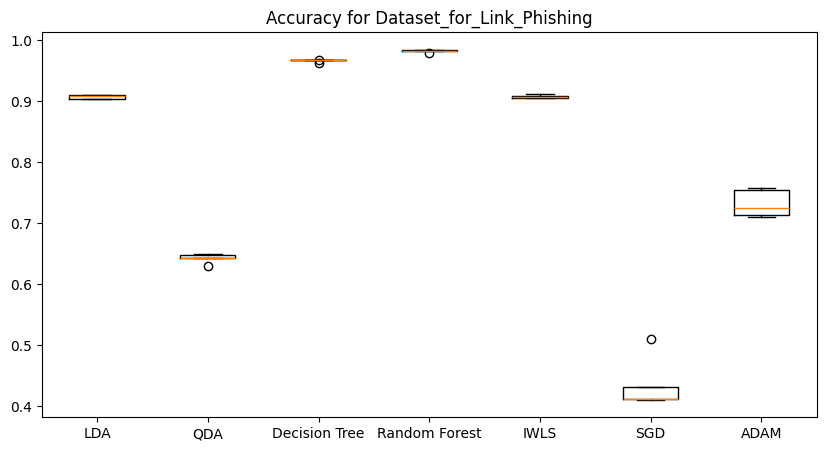

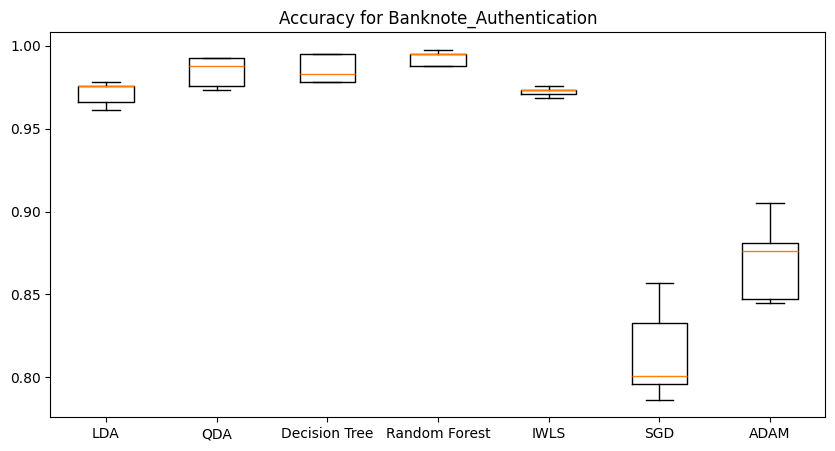

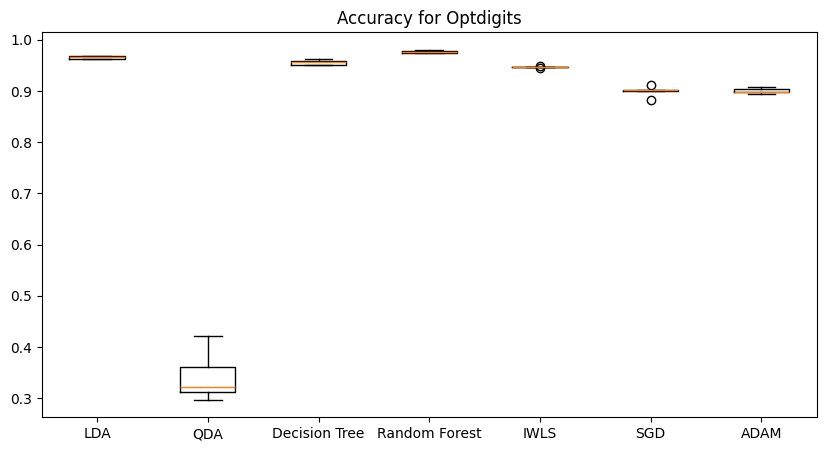

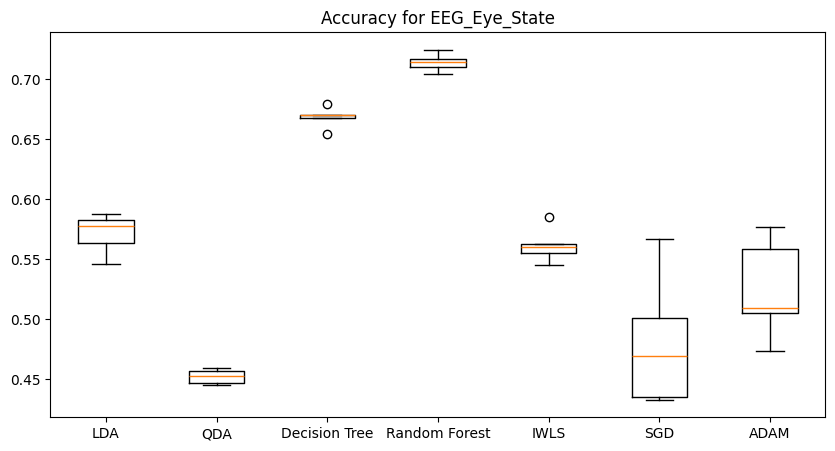

In [39]:
# Plot boxplots only for accuracy

import matplotlib.pyplot as plt

for dataset_name, results_by_method in results_by_dataset_and_method.items():
    accuracies = []
    method_names = []
    for method_name, results in results_by_method.items():
        accuracies.append(results["accuracy"])
        method_names.append(method_name)
    
    plt.figure(figsize=(10, 5))
    plt.boxplot(accuracies)
    plt.xticks(range(1, len(method_names) + 1), method_names)
    plt.title(f"Accuracy for {dataset_name}")
    plt.show()

# Task 3.5
In the case of small datasets, please compare the two versions of the logistic regression: model without interactions and model with interactions. This gives a total of 6 variants of logistic regression (IWLS, SGD, ADAM, IWLS+INT, SGD+INT, ADAM+INT).


In [ ]:
# Infuse IWLS with interactions
import traceback
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

iterations = 10
test_size = 0.3

methods = [
    ("IWLS", False, lambda: IRLS(iter_limit=10)),
    ("IWLS+INT", True, lambda: IRLS(iter_limit=10)),
    ("SGD", False, lambda: SGD(iter_limit=500)),
    ("SGD+INT", True, lambda: SGD(iter_limit=500)),
    ("ADAM", False, lambda: ADAM(iter_limit=500)),
    ("ADAM+INT", True, lambda: ADAM(iter_limit=500)),
]

small_datasets = {
    'Rice_Cammeo_Osmancik': datasets['Rice_Cammeo_Osmancik'],
    'Statlog_Shuttle': datasets['Statlog_Shuttle'],
    'Banknote_Authentication': datasets['Banknote_Authentication'],
}

results_by_dataset_and_method_35 = {}

# Load saved results
import json

try:
    with open('results_3.5.json', 'r') as f:
        results_by_dataset_and_method_35 = json.load(f)
        print("Loaded results from file")
except FileNotFoundError:
    pass


# First collect results
for dataset_name, dataset in small_datasets.items():
    if dataset_name in results_by_dataset_and_method_35:
        print(f"Skipping {dataset_name}")
        continue
    
    results_by_method = {}
    for method_name, should_use_interactions, method in methods:
        results = {
            "accuracy": [],
            "f1": [],
            "precision": [],
            "recall": []
        }
        
        tqdm._instances.clear()
        
        bar = tqdm(total=iterations)
        bar.set_description(f"Processing {method_name} on {dataset_name}")
        max_attempts = 10
        current_iteration = 0
        while current_iteration < iterations:
            try:
                X, y = dataset
                method_instance = method()
    
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
                
                interactions = [
                    (i, j)
                    for i in range(X_train.shape[1])
                    for j in range(i + 1, X_train.shape[1])
                ]
                
                if not should_use_interactions:
                    method_instance.fit(X_train, y_train)
                else:
                    method_instance.fit(
                        X_train, 
                        y_train, 
                        interactions=interactions
                    )
                
                y_pred = (
                    method_instance.predict(X_test)
                    if not should_use_interactions
                    else method_instance.predict(X_test, interactions=interactions)
                )
                results["accuracy"].append(accuracy_score(y_test, y_pred))
                results["f1"].append(f1_score(y_test, y_pred))
                results["precision"].append(precision_score(y_test, y_pred))
                results["recall"].append(recall_score(y_test, y_pred))

                bar.update(1)
                current_iteration += 1
            except Exception as e:
                print(f"Error in {method_name} on {dataset_name} iteration {current_iteration}: {e}, attempts left: {max_attempts}")
                traceback.print_exc()
                max_attempts -= 1
                
                if max_attempts == 0:
                    raise
            
        bar.close()
        results_by_method[method_name] = results
    results_by_dataset_and_method_35[dataset_name] = results_by_method
    
    # Save results
    with open('results_3.5.json', 'w') as f:
        json.dump(results_by_dataset_and_method_35, f)


Processing SGD+INT on Rice_Cammeo_Osmancik:  30%|███       | 3/10 [00:27<01:03,  9.11s/it]

In [ ]:
# Save results
import json

with open('results_3.5.json', 'w') as f:
    json.dump(results_by_dataset_and_method_35, f)

In [ ]:
results_by_dataset_and_method_35

In [ ]:
# Plot boxplots only for accuracy

import matplotlib.pyplot as plt

for dataset_name, results_by_method in results_by_dataset_and_method_35.items():
    accuracies = []
    method_names = []
    for method_name, results in results_by_method.items():
        accuracies.append(results["accuracy"])
        method_names.append(method_name)
    
    plt.figure(figsize=(10, 5))
    plt.boxplot(accuracies)
    plt.xticks(range(1, len(method_names) + 1), method_names)
    plt.title(f"Accuracy for {dataset_name}")
    plt.show()